##   This notebook includes correlation data, logistic regression and confusion matrix code

In [53]:
#read in combined motorcycle crash data
motorcycle_data <- read.csv("Datasets/statecycle_flag.csv",
                       encoding='latin-1')

In [54]:
#remove some unnecessary variables
motorcycle_data<-within(motorcycle_data, rm('X','MC_PASSNGR_IND', 'MC_DVR_HLMTDOT_IND', 'MC_PAS_HLMTDOT_IND',
                           'MINOR_INJURY','MODERATE_INJURY','MAJOR_INJURY','CRN', 
                           'FATAL_OR_MAJ_INJ','CRASH_YEAR','COUNTY','MUNICIPALITY','COUNTY_YEAR',
                           'MOTORCYCLE_COUNT','FATAL_COUNT','MCYCLE_DEATH_COUNT','DEC_LAT','DEC_LONG',
                           'PSP_REPORTED','MC_DVR_HLMT_TYPE','MC_PAS_HLMT_TYPE','MC_PAS_HLMTON_IND'))


Turn the y/n column about whether the motorcycle driver is wearing a helmet into separate binary columns

In [55]:
#one hot encode driver wearing helmet column

for(unique_value in unique(motorcycle_data$MC_DVR_HLMTON_IND)){
motorcycle_data[paste(" MC_DVR_HLMTON_IND", unique_value, sep = ".")] <- ifelse(motorcycle_data$MC_DVR_HLMTON_IND == unique_value, 1, 0)
}


In [56]:
#These are the variables we have now

str(motorcycle_data)

'data.frame':	96508 obs. of  90 variables:
 $ MC_DVR_HLMTON_IND   : Factor w/ 4 levels " ","N","U","Y": 1 1 3 3 1 3 1 1 1 1 ...
 $ INTERSTATE          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ STATE_ROAD          : int  1 0 0 0 1 1 1 0 0 1 ...
 $ LOCAL_ROAD          : int  1 1 1 1 0 0 0 1 1 0 ...
 $ LOCAL_ROAD_ONLY     : int  0 1 1 1 0 0 0 1 1 0 ...
 $ TURNPIKE            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ WET_ROAD            : int  1 0 1 0 1 1 1 1 1 0 ...
 $ SNOW_SLUSH_ROAD     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ICY_ROAD            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ SUDDEN_DEER         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ SHLDR_RELATED       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ REAR_END            : int  0 0 0 0 0 0 0 0 1 1 ...
 $ HO_OPPDIR_SDSWP     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ HIT_FIXED_OBJECT    : int  0 0 1 0 0 1 0 0 0 0 ...
 $ SV_RUN_OFF_RD       : int  0 0 1 1 0 1 0 0 0 0 ...
 $ WORK_ZONE           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ PROPERTY_DAMAGE_ONLY: int  0 0 0 0 0 0 0 0 0 0 ...
 $ INJUR

In [57]:
#remove original driver wearing helmet column
motorcycle_data<-within(motorcycle_data, rm('MC_DVR_HLMTON_IND'))


Next, I'm selecting just the 5 varibales that were calculated in my feature selection notebook: phantom vehicle, alcohol related, 65 mph speed limit zone, drugged driver and hazardous truck. I will come back to these for the logistic regression.

In [58]:
select_data <- motorcycle_data[c('FATAL','PHANTOM_VEHICLE','ALCOHOL_RELATED','LIMIT_65MPH','HAZARDOUS_TRUCK','DRUGGED_DRIVER')]
str(select_data)

'data.frame':	96508 obs. of  6 variables:
 $ FATAL          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ PHANTOM_VEHICLE: int  0 0 0 0 0 0 0 0 0 0 ...
 $ ALCOHOL_RELATED: int  0 0 0 0 0 1 0 0 0 0 ...
 $ LIMIT_65MPH    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ HAZARDOUS_TRUCK: int  0 0 0 0 0 0 0 0 0 0 ...
 $ DRUGGED_DRIVER : int  0 0 0 0 0 0 0 0 0 0 ...


In [59]:
#remove any rows with all zeroes and check to see if any were rmoved. None were.
    
select_data <-select_data[apply(select_data, 1, function(x) any(x != '')), ]
str(select_data)    

'data.frame':	96508 obs. of  6 variables:
 $ FATAL          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ PHANTOM_VEHICLE: int  0 0 0 0 0 0 0 0 0 0 ...
 $ ALCOHOL_RELATED: int  0 0 0 0 0 1 0 0 0 0 ...
 $ LIMIT_65MPH    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ HAZARDOUS_TRUCK: int  0 0 0 0 0 0 0 0 0 0 ...
 $ DRUGGED_DRIVER : int  0 0 0 0 0 0 0 0 0 0 ...


## Correlation calculations and plot

In [60]:

#calculate the correlation coefficients between the variables
select <- cor(select_data)
round(select, 2)

,FATAL,PHANTOM_VEHICLE,ALCOHOL_RELATED,LIMIT_65MPH,HAZARDOUS_TRUCK,DRUGGED_DRIVER
FATAL,1.00,-0.01,0.19,0.01,0.03,0.12
PHANTOM_VEHICLE,-0.01,1.00,-0.03,0.00,0.00,-0.01
ALCOHOL_RELATED,0.19,-0.03,1.00,-0.01,0.00,0.17
LIMIT_65MPH,0.01,0.00,-0.01,1.00,0.00,0.00
HAZARDOUS_TRUCK,0.03,0.00,0.00,0.00,1.00,0.00
DRUGGED_DRIVER,0.12,-0.01,0.17,0.00,0.00,1.00


In [61]:
#correlation score for selected data, using only complete observations

cor(select, method = "pearson", use = "complete.obs")


,FATAL,PHANTOM_VEHICLE,ALCOHOL_RELATED,LIMIT_65MPH,HAZARDOUS_TRUCK,DRUGGED_DRIVER
FATAL,1.00000000,-0.2983695,0.14251492,-0.2539668,-0.2278451,-0.01257574
PHANTOM_VEHICLE,-0.29836950,1.0000000,-0.33425356,-0.1886150,-0.2007031,-0.27957890
ALCOHOL_RELATED,0.14251492,-0.3342536,1.00000000,-0.3025426,-0.2708807,0.09530466
LIMIT_65MPH,-0.25396682,-0.1886150,-0.30254259,1.0000000,-0.1994725,-0.27198716
HAZARDOUS_TRUCK,-0.22784506,-0.2007031,-0.27088073,-0.1994725,1.0000000,-0.26370532
DRUGGED_DRIVER,-0.01257574,-0.2795789,0.09530466,-0.2719872,-0.2637053,1.00000000


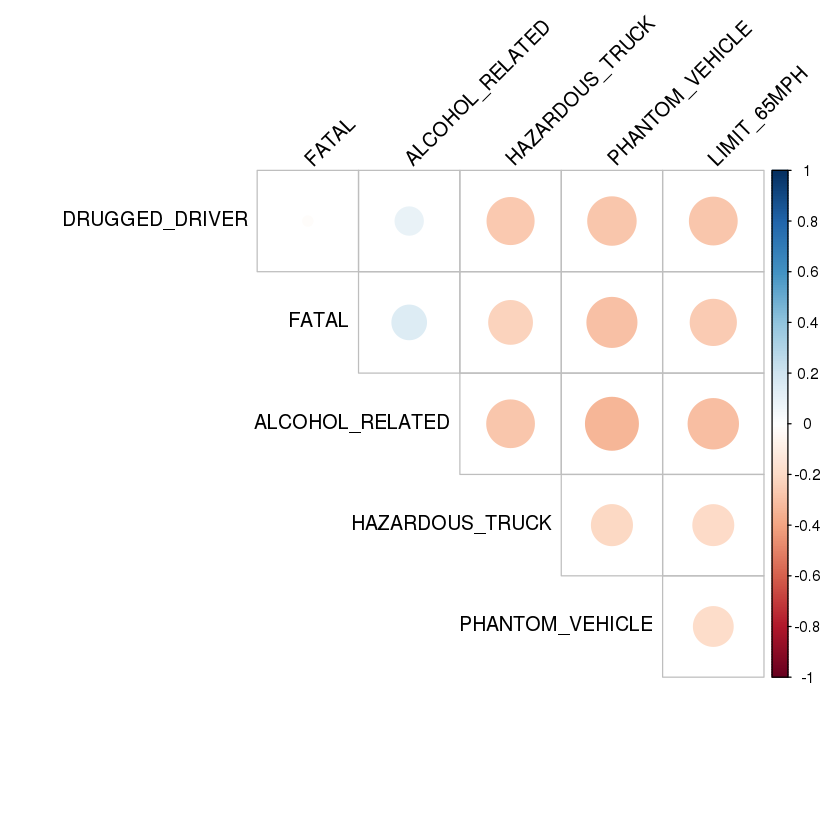

In [63]:
#plot the correlations
library(corrplot)
corrplot(cor(select, use = "complete"), type = "upper", order = "hclust", diag=FALSE,
  tl.col = "black", tl.srt = 45)

Here I'm experimenting with different plot styles. I ended up using the one above because I thought it was the clearest, but I left this on here to see how I could change the look.

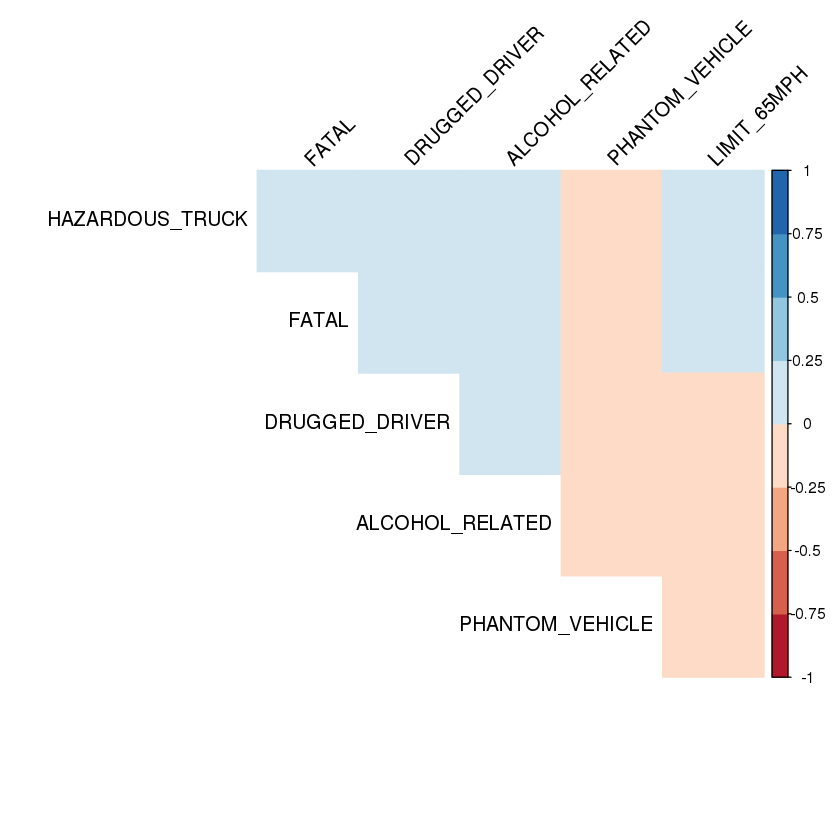

In [64]:
library(RColorBrewer)
#col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))
corrplot(select,method="color", col=brewer.pal(n=8, name="RdBu"),  
         type="upper", order="AOE", 
         #addCoef.col = "black", # Add coefficient of correlation
         tl.col="black", tl.srt=45, #Text label color and rotation
         # Combine with significance
         #p.mat = p.mat, sig.level = 0.01, insig = "p-value", 
         # hide correlation coefficient on the principal diagonal
         diag=FALSE
         )


#correlation plot for selected data
library(corrplot)
corrplot(select, type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 45)

## Logistic Regression on five selected variables

In [65]:
#Count the number of fatal accidents in the data set.

table(select_data$FATAL)



    0     1 
92761  3747 

In [66]:
#create equal sample size of fatal and nonfatals
input_ones <- select_data[which(select_data$FATAL == 1), ]  # all 1's
input_zeros <- select_data[which(select_data$FATAL == 0), ]  # all 0's
set.seed(100)  # for repeatability of samples
input_ones_training_rows <- sample(1:nrow(input_ones), 0.7*nrow(input_ones))  # 1's for training
input_zeros_training_rows <- sample(1:nrow(input_zeros), 0.7*nrow(input_ones))  # 0's for training. Pick as many 0's as 1's
training_ones <- input_ones[input_ones_training_rows, ]  
training_zeros <- input_zeros[input_zeros_training_rows, ]
trainingData <- rbind(training_ones, training_zeros)  # row bind the 1's and 0's 

# Create Test Data
test_ones <- input_ones[-input_ones_training_rows, ]
test_zeros <- input_zeros[-input_zeros_training_rows, ]
testData <- rbind(test_ones, test_zeros)  # row bind the 1's and 0's 


In [67]:
#run the regression on the training data that we split out above and calculate predictions on the test data

logitMod <- glm(FATAL ~ PHANTOM_VEHICLE + ALCOHOL_RELATED + LIMIT_65MPH + HAZARDOUS_TRUCK + DRUGGED_DRIVER, data=trainingData, family=binomial(link="logit"))

predicted <- plogis(predict(logitMod, testData))  # predicted scores


In [68]:
#show a summary of the regression
summary(logitMod)


Call:
glm(formula = FATAL ~ PHANTOM_VEHICLE + ALCOHOL_RELATED + LIMIT_65MPH + 
    HAZARDOUS_TRUCK + DRUGGED_DRIVER, family = binomial(link = "logit"), 
    data = trainingData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7225  -0.9981  -0.4988   1.3680   1.3680  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.43756    0.03281 -13.334   <2e-16 ***
PHANTOM_VEHICLE   0.00921    0.25963   0.035   0.9717    
ALCOHOL_RELATED   1.91817    0.08576  22.367   <2e-16 ***
LIMIT_65MPH       0.79231    0.26879   2.948   0.0032 ** 
HAZARDOUS_TRUCK  13.37080  190.90946   0.070   0.9442    
DRUGGED_DRIVER    2.20053    0.26128   8.422   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7269.7  on 5243  degrees of freedom
Residual deviance: 6443.0  on 5238  degrees of freedom
AIC: 6455

Number of Fisher Scoring iterations: 12

In [69]:
#calculate the importance of the variables in the model
varImp(logitMod)

,Overall
PHANTOM_VEHICLE,0.03547294
ALCOHOL_RELATED,22.36657053
LIMIT_65MPH,2.94773223
HAZARDOUS_TRUCK,0.07003740
DRUGGED_DRIVER,8.42221261


## Confusion matrix

Below is the caret library code to create a confusion matrix. A '0' means there was no fatality and a '1' means there was a fatality. The model is very good at prediciting when there isn't a fatality but not as accurate at predicting fatalities. 


In [70]:
library(caret)
predicted<-ifelse(predicted> 0.5,1,0)
cm<- confusionMatrix(testData$FATAL, predicted)
cm$table

          Reference
Prediction     0     1
         0 81768  8371
         1   674   451

The code below creates a fancier confusion matrix graphic. I wanted something easier to understand for the average reader than just the table above and I found this code, and changed the colors and labels.


In [71]:
draw_confusion_matrix <- function(cm) {

  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('Motorcycle Fatalities', cex.main=2)

  # create the matrix 
  rect(150, 430, 240, 370, col='#4ebce8')
  text(195, 435, 'No Fatality', cex=1.2)
  rect(250, 430, 340, 370, col='#7c0d18')
  text(295, 435, 'Fatality', cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col='#7c0d18')
  rect(250, 305, 340, 365, col='#4ebce8')
  text(140, 400, 'No Fatality', cex=1.2, srt=90)
  text(140, 335, 'Fatality', cex=1.2, srt=90)

  # add in the cm results 
  res <- as.numeric(cm$table)
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')

  # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$byClass[1]), 3), cex=1.2)
  text(30, 85, names(cm$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$byClass[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)

  # add in the accuracy information 
  text(30, 35, names(cm$overall[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(cm$overall[1]), 3), cex=1.4)
  text(70, 35, names(cm$overall[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(cm$overall[2]), 3), cex=1.4)
}  

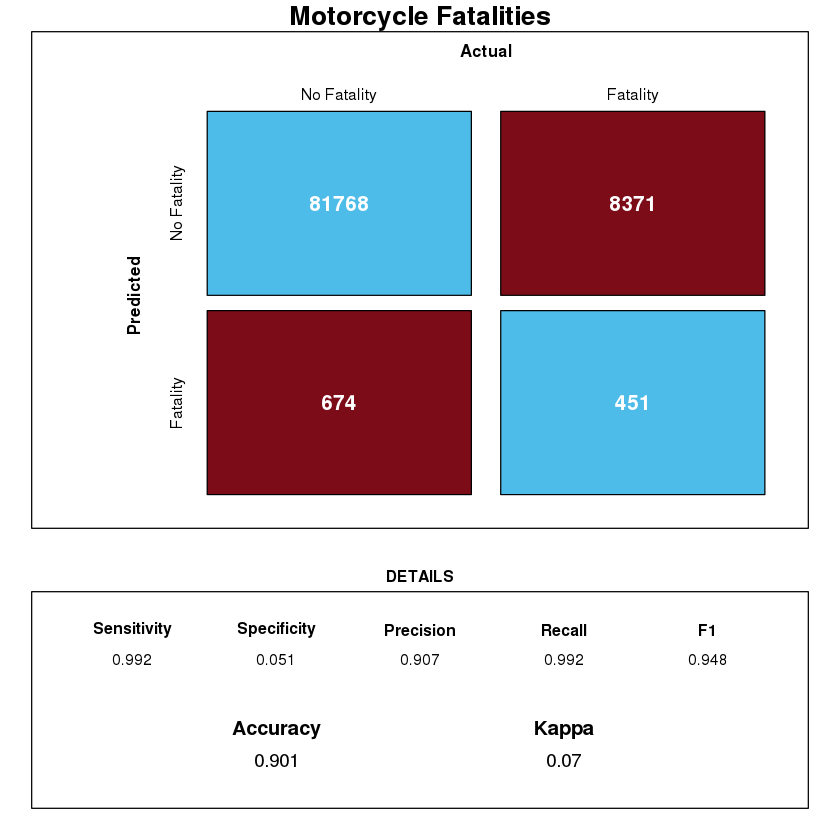

In [72]:
draw_confusion_matrix(cm)


## Logistic Regression using top two variables

Next, I wanted to run the regression using just drugged driver and alcohol related, since those were the two most important variables.

In [73]:
#choose those two variables from the dataset
select_data2 <- motorcycle_data[c('FATAL','ALCOHOL_RELATED','DRUGGED_DRIVER')]
head(select_data2)

FATAL,ALCOHOL_RELATED,DRUGGED_DRIVER
0,0,0
0,0,0
0,0,0
0,0,0
0,0,0
0,1,0


In [74]:
#create equal sample size of fatal and nonfatals
input_ones <- select_data[which(select_data2$FATAL == 1), ]  # all 1's
input_zeros <- select_data[which(select_data2$FATAL == 0), ]  # all 0's
set.seed(100)  # for repeatability of samples
input_ones_training_rows <- sample(1:nrow(input_ones), 0.7*nrow(input_ones))  # 1's for training
input_zeros_training_rows <- sample(1:nrow(input_zeros), 0.7*nrow(input_ones))  # 0's for training. Pick as many 0's as 1's
training_ones <- input_ones[input_ones_training_rows, ]  
training_zeros <- input_zeros[input_zeros_training_rows, ]
trainingData <- rbind(training_ones, training_zeros)  # row bind the 1's and 0's 

# Create Test Data
test_ones <- input_ones[-input_ones_training_rows, ]
test_zeros <- input_zeros[-input_zeros_training_rows, ]
testData <- rbind(test_ones, test_zeros)  # row bind the 1's and 0's 


In [75]:
#run the regression on the training data that we split out above and calculate predictions on the test data

logitMod <- glm(FATAL ~ ALCOHOL_RELATED + DRUGGED_DRIVER, data=trainingData, family=binomial(link="logit"))

predicted <- plogis(predict(logitMod, testData))

In [76]:
#show a summary of the regression

summary(logitMod)


Call:
glm(formula = FATAL ~ ALCOHOL_RELATED + DRUGGED_DRIVER, family = binomial(link = "logit"), 
    data = trainingData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7270  -1.0034  -0.3908   1.3620   1.3620  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -0.42417    0.03233 -13.121   <2e-16 ***
ALCOHOL_RELATED  1.91518    0.08564  22.364   <2e-16 ***
DRUGGED_DRIVER   2.20261    0.26109   8.436   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7269.7  on 5243  degrees of freedom
Residual deviance: 6460.2  on 5241  degrees of freedom
AIC: 6466.2

Number of Fisher Scoring iterations: 5


In [77]:
#create basic confusion matrix
library(caret)
predicted<-ifelse(predicted> 0.5,1,0)
cm<- confusionMatrix(testData$FATAL, predicted)
cm$table

          Reference
Prediction     0     1
         0 82756  7383
         1   696   429

On the new confusion matrix, the overall model is more accurate, but it is even worse at predicting fatalities. Fatal crashes predicted accurately went from 451 to 429.

In [78]:
#create fancy confusion matrix graph

draw_confusion_matrix <- function(cm) {

  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('Motorcycle Fatalities', cex.main=2)

  # create the matrix 
  rect(150, 430, 240, 370, col='#4ebce8')
  text(195, 435, 'No Fatality', cex=1.2)
  rect(250, 430, 340, 370, col='#7c0d18')
  text(295, 435, 'Fatality', cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col='#7c0d18')
  rect(250, 305, 340, 365, col='#4ebce8')
  text(140, 400, 'No Fatality', cex=1.2, srt=90)
  text(140, 335, 'Fatality', cex=1.2, srt=90)

  # add in the cm results 
  res <- as.numeric(cm$table)
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')

  # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$byClass[1]), 3), cex=1.2)
  text(30, 85, names(cm$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$byClass[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)

  # add in the accuracy information 
  text(30, 35, names(cm$overall[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(cm$overall[1]), 3), cex=1.4)
  text(70, 35, names(cm$overall[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(cm$overall[2]), 3), cex=1.4)
}  

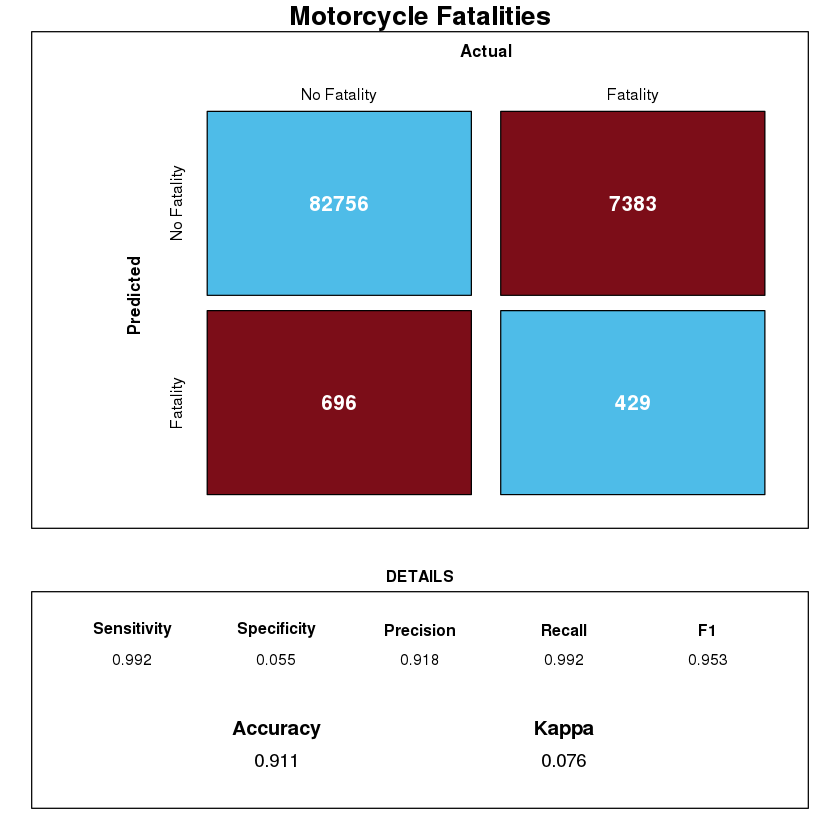

In [79]:
draw_confusion_matrix(cm)


In the cell below I just wanted to sum the variables to see how many instances of each kind there were. I used some of that data in my story.

In [80]:

sum(select_data$ALCOHOL_RELATED)

sum(select_data$DRUGGED_DRIVER)

sum(select_data$PHANTOM_VEHICLE)

sum(select_data$LIMIT_65MPH)

sum(select_data$HAZARDOUS_TRUCK)

[1] 8586

[1] 1038

[1] 1453

[1] 1105

[1] 33